<a href="https://colab.research.google.com/github/zeerafle/fraud-detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data Preprocessing and Exploration

### Get the [Kaggle Credit Card Fraud](https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTrain.csv) data set

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%%bash
pip install kaggle
mkdir ~/.kaggle
cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download -d kartik2112/fraud-detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



100%|██████████| 202M/202M [00:02<00:00, 87.6MB/s]


In [5]:
%%bash
mkdir data
unzip fraud-detection.zip -d data

Archive:  fraud-detection.zip
  inflating: data/fraudTest.csv      
  inflating: data/fraudTrain.csv     


In [6]:
pd.read_csv('data/fraudTrain.csv').columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [7]:
file = tf.keras.utils
raw_df = pd.read_csv('data/fraudTrain.csv')
raw_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [8]:
raw_df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [9]:
UNWANTED_COLS = ['cc_num', 'first', 'last',
                 'street', 'city', 'state',
                 'zip', 'trans_num', 'unix_time',
                 'merchant', 'job']

raw_df = raw_df.iloc[:, 1:]
raw_df.drop(columns=UNWANTED_COLS, inplace=True)
raw_df.shape

(1296675, 11)

### Examine the class label imbalance

In [10]:
neg, pos = np.bincount(raw_df['is_fraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1296675
    Positive: 7506 (0.58% of total)



### Feature Engineering

#### Getting person's age

In [11]:
trans_date = pd.to_datetime(raw_df.trans_date_trans_time, format="%Y-%m-%d %H:%M:%S")
dob = pd.to_datetime(raw_df.dob, format="%Y-%m-%d")

raw_df['age_when_trans'] = trans_date.map(lambda x: x.year) - dob.map(lambda x: x.year)
raw_df.age_when_trans

0          31
1          41
2          57
3          52
4          33
           ..
1296670    59
1296671    41
1296672    53
1296673    40
1296674    25
Name: age_when_trans, Length: 1296675, dtype: int64

(array([ 81311., 174087., 244642., 226105., 204589., 145037.,  98846.,
         54931.,  36709.,  30418.]),
 array([14. , 22.2, 30.4, 38.6, 46.8, 55. , 63.2, 71.4, 79.6, 87.8, 96. ]),
 <a list of 10 Patch objects>)

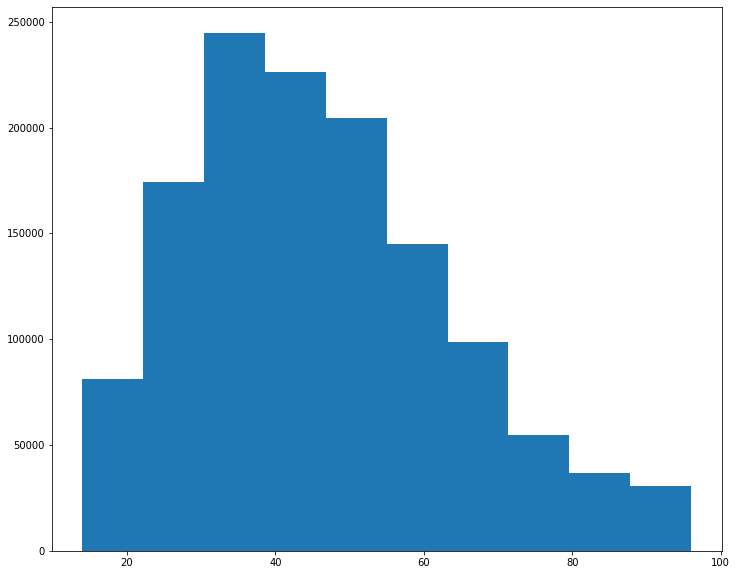

In [12]:
plt.hist(raw_df.age_when_trans)

#### Get time hour discrete value

In [13]:
raw_df['time_hour'] = trans_date.map(lambda x: x.hour)
raw_df.time_hour

0           0
1           0
2           0
3           0
4           0
           ..
1296670    12
1296671    12
1296672    12
1296673    12
1296674    12
Name: time_hour, Length: 1296675, dtype: int64

In [14]:
raw_df.time_hour.value_counts()

23    67104
22    66982
18    66051
16    65726
21    65533
19    65508
17    65450
15    65391
13    65314
12    65257
20    65098
14    64885
1     42869
3     42769
2     42656
8     42505
0     42502
6     42300
10    42271
7     42203
9     42185
5     42171
11    42082
4     41863
Name: time_hour, dtype: int64

(array([128027.,  84632.,  84471., 126893.,  84353., 130571., 196002.,
        131501., 130606., 199619.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

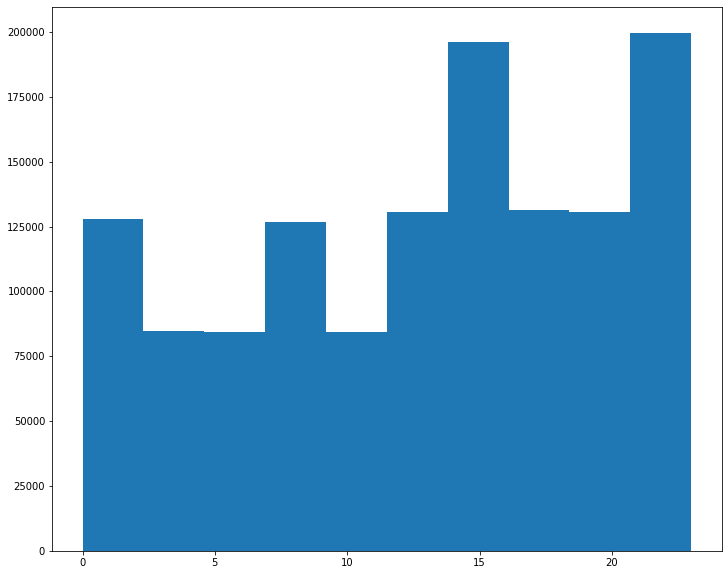

In [15]:
plt.hist(raw_df.time_hour)

#### Get day of week discrete value

In [16]:
print(trans_date[13820])
print(trans_date[0].weekday())

2019-01-08 19:04:00
1


In [17]:
raw_df['weekday'] = trans_date.map(lambda x: x.weekday())
raw_df.weekday

0          1
1          1
2          1
3          1
4          1
          ..
1296670    6
1296671    6
1296672    6
1296673    6
1296674    6
Name: weekday, Length: 1296675, dtype: int64

<BarContainer object of 7 artists>

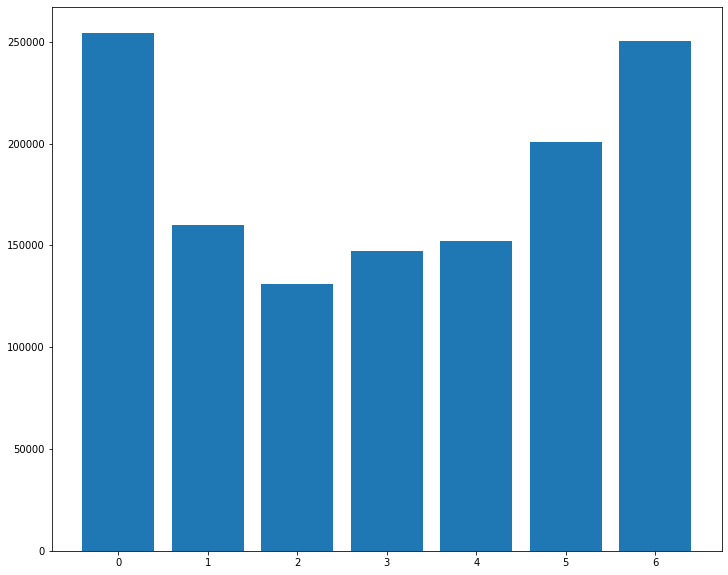

In [18]:
plt.bar(raw_df.weekday.value_counts().index, raw_df.weekday.value_counts())

#### Get distance between credit card owner and merchant

Distance is calculated with euclidean distance on each latitude and longitude value

In [19]:
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return np.sqrt(londiff*londiff + latdiff*latdiff)

In [20]:
raw_df['distance'] = raw_df[['lat', 'long', 'merch_lat', 'merch_long']].apply(euclidean, axis=1)
raw_df.distance

0          0.872830
1          0.272310
2          0.975845
3          0.919802
4          0.868505
             ...   
1296670    1.177732
1296671    0.819632
1296672    0.967541
1296673    0.898775
1296674    0.786883
Name: distance, Length: 1296675, dtype: float64

#### Apply the same preprocessing to test data

In [21]:
def feat_eng(df):
    UNWANTED_COLS = ['cc_num', 'first', 'last',
                    'street', 'city', 'state',
                    'zip', 'trans_num', 'unix_time',
                    'merchant', 'job']

    raw_df = df.iloc[:, 1:]
    raw_df.drop(columns=UNWANTED_COLS, inplace=True)
    
    trans_date = pd.to_datetime(raw_df.trans_date_trans_time, format="%Y-%m-%d %H:%M:%S")
    dob = pd.to_datetime(raw_df.dob, format="%Y-%m-%d")

    raw_df['age_when_trans'] = trans_date.map(lambda x: x.year) - dob.map(lambda x: x.year)
    raw_df['time_hour'] = trans_date.map(lambda x: x.hour)
    raw_df['weekday'] = trans_date.map(lambda x: x.weekday())
    raw_df['distance'] = raw_df[['lat', 'long', 'merch_lat', 'merch_long']].apply(euclidean, axis=1)

    return raw_df.drop(columns=['trans_date_trans_time', 'dob'])

#### Split Data

In [22]:
LABEL_COLUMN = 'is_fraud'

In [23]:
train_df = raw_df.drop(columns=['trans_date_trans_time', 'dob'])
train_df.head()

,category,amt,gender,lat,long,city_pop,merch_lat,merch_long,is_fraud,age_when_trans,time_hour,weekday,distance
0,misc_net,4.97,F,36.0788,-81.1781,3495,36.011293,-82.048315,0,31,0,1,0.872830
1,grocery_pos,107.23,F,48.8878,-118.2105,149,49.159047,-118.186462,0,41,0,1,0.272310
2,entertainment,220.11,M,42.1808,-112.2620,4154,43.150704,-112.154481,0,57,0,1,0.975845
3,gas_transport,45.00,M,46.2306,-112.1138,1939,47.034331,-112.561071,0,52,0,1,0.919802
4,misc_pos,41.96,M,38.4207,-79.4629,99,38.674999,-78.632459,0,33,0,1,0.868505


In [24]:
test_df = pd.read_csv('data/fraudTest.csv')
print(f'before feature engineering: {test_df.shape}')

test_df = feat_eng(test_df)
print(f'after feature engineering: {test_df.shape}')

before feature engineering: (555719, 23)
after feature engineering: (555719, 13)


In [25]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, val_df = train_test_split(train_df, test_size=0.2)

## Keras Preprocessing Layer

### Create Tensorflow dataset

In [26]:
CATEGORICAL_COLS = ['category', 'gender']
DISCRETE_COLS = ['time_hour', 'weekday']
NUMERIC_COLS = ['amt', 'city_pop', 'lat',
                'long', 'merch_lat', 'merch_long',
                'age_when_trans', 'distance']

In [27]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(LABEL_COLUMN)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [28]:
BATCH_SIZE = 2048
train_ds = df_to_dataset(train_df, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(val_df, shuffle=False, batch_size=BATCH_SIZE)

In [29]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of households:', feature_batch['city_pop'])
    print('A batch of ocean_proximity:', feature_batch['gender'])
    print('A batch of trans datetime:', feature_batch['age_when_trans'])
    print('A batch of targets:', label_batch)

Every feature: ['category', 'amt', 'gender', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age_when_trans', 'time_hour', 'weekday', 'distance']
A batch of households: tf.Tensor([ 16183    798   1766 ... 973849   7155  76383], shape=(2048,), dtype=int64)
A batch of ocean_proximity: tf.Tensor([b'F' b'M' b'F' ... b'F' b'F' b'M'], shape=(2048,), dtype=string)
A batch of trans datetime: tf.Tensor([43 94 43 ... 23 42 34], shape=(2048,), dtype=int64)
A batch of targets: tf.Tensor([0 0 0 ... 0 0 0], shape=(2048,), dtype=int64)


### Create input pipeline

In [30]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [31]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [32]:
all_inputs = dict()
encoded_features = []

In [33]:
# Numerical features.
for header in NUMERIC_COLS:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs[header] = numeric_col
    encoded_features.append(encoded_numeric_col)

In [34]:
for header in CATEGORICAL_COLS:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs[header] = categorical_col
    encoded_features.append(encoded_categorical_col)

In [35]:
for header in DISCRETE_COLS:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='int64')
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs[header] = categorical_col
    encoded_features.append(encoded_categorical_col)

In [36]:
all_inputs

{'amt': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'amt')>,
 'city_pop': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'city_pop')>,
 'lat': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lat')>,
 'long': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'long')>,
 'merch_lat': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'merch_lat')>,
 'merch_long': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'merch_long')>,
 'age_when_trans': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age_when_trans')>,
 'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
 'category': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'category')>,
 'gender': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'gender')>,
 'time_hour': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'time_hour')>,
 'weekday': <KerasTensor: shape=(None

In [37]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_7')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 25) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'cat

In [38]:
all_inputs_list = list(all_inputs.values())
all_inputs_list

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'amt')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'city_pop')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lat')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'long')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'merch_lat')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'merch_long')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age_when_trans')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'category')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'gender')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'time_hour')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'weekday')>]

## Build the Model and Metrics

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [76]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dense(32, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.L1(0.001),
                              activity_regularizer=tf.keras.regularizers.L2(0.001))(x)
    x = tf.keras.layers.Dense(16, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid',
                                   bias_initializer=output_bias)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS)

    return model


In [41]:
initial_bias = np.log([pos/neg])
initial_bias

array([-5.1460504])

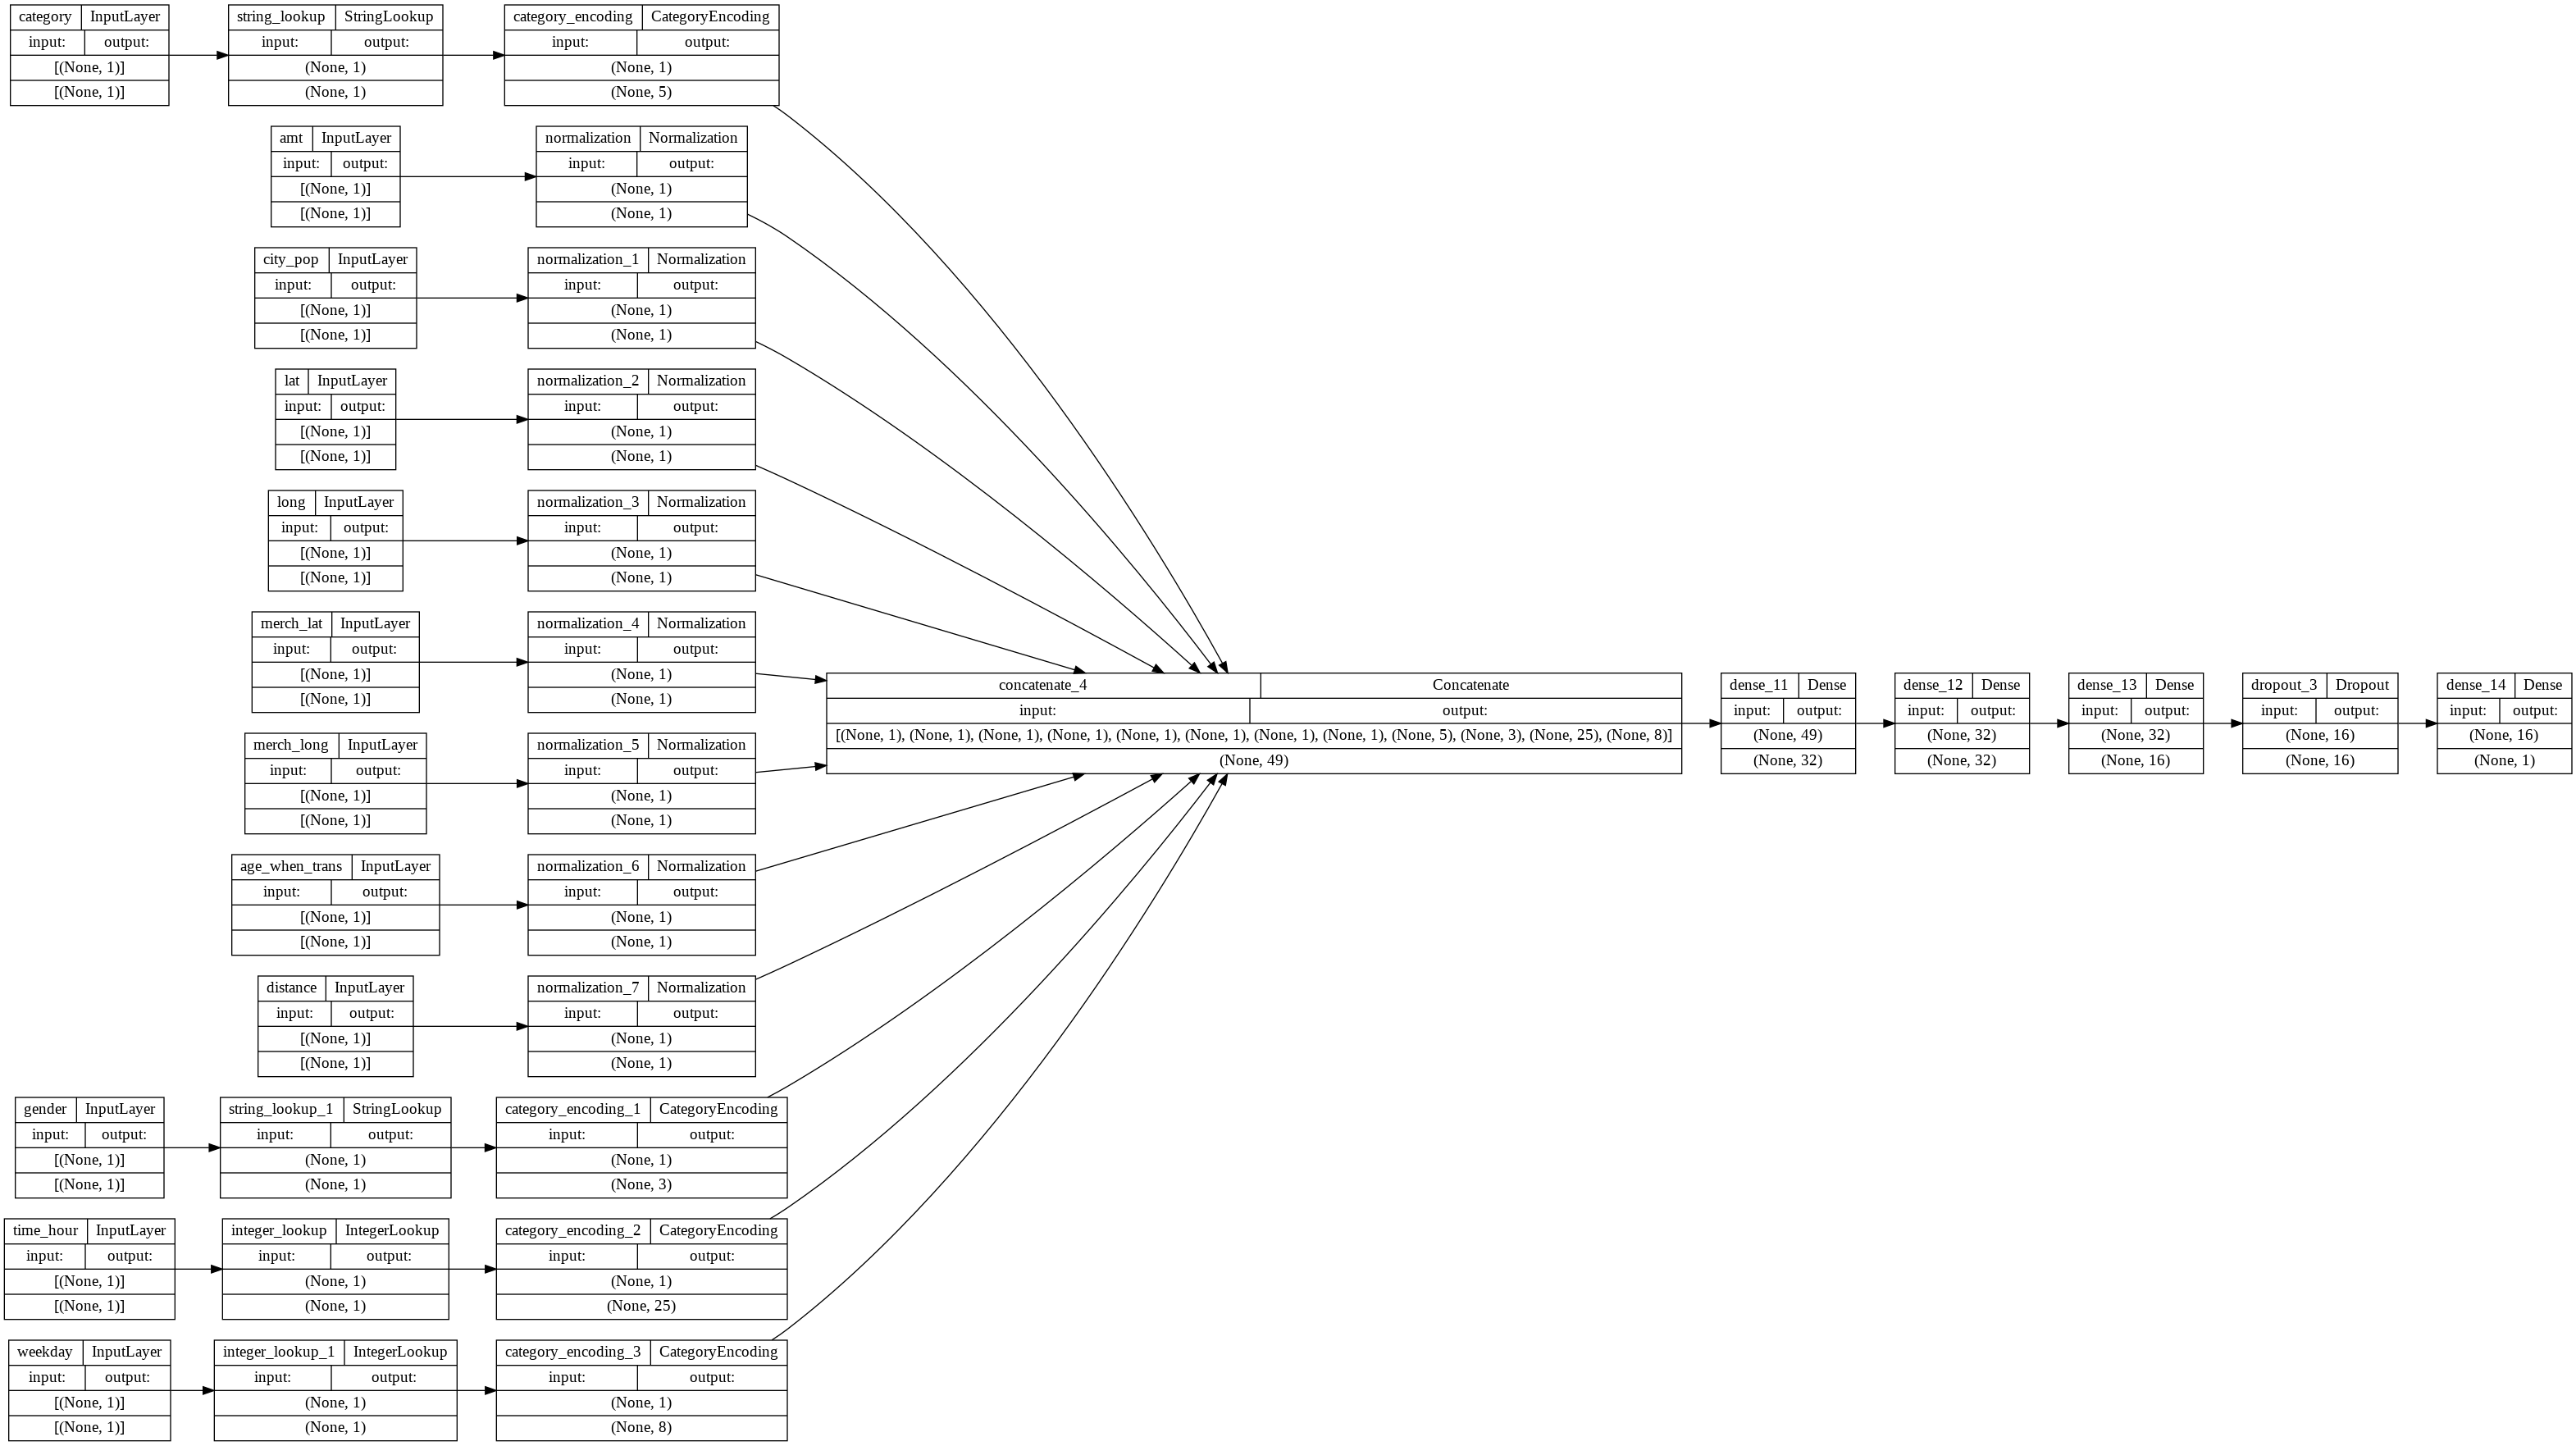

In [77]:
model = make_model(output_bias=initial_bias)
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [78]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 category (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 time_hour (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 weekday (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

### Class weights

In [80]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [45]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 86.38


#### Train with class weights

In [81]:
model.load_weights(initial_weights)
weighted_history = model.fit(
    train_ds,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_ds,
    # class weights
    class_weight=class_weight)

Epoch 1/100
507/507 [==============================] - 20s 28ms/step - loss: 0.9097 - tp: 3542.0000 - fp: 98840.0000 - tn: 932497.0000 - fn: 2461.0000 - accuracy: 0.9023 - precision: 0.0346 - recall: 0.5900 - auc: 0.7852 - prc: 0.1204 - val_loss: 0.3641 - val_tp: 1210.0000 - val_fp: 22058.0000 - val_tn: 235774.0000 - val_fn: 293.0000 - val_accuracy: 0.9138 - val_precision: 0.0520 - val_recall: 0.8051 - val_auc: 0.9477 - val_prc: 0.2630
Epoch 2/100
507/507 [==============================] - 17s 26ms/step - loss: 0.5389 - tp: 4577.0000 - fp: 100920.0000 - tn: 930417.0000 - fn: 1426.0000 - accuracy: 0.9013 - precision: 0.0434 - recall: 0.7625 - auc: 0.9081 - prc: 0.1694 - val_loss: 0.3194 - val_tp: 1279.0000 - val_fp: 22627.0000 - val_tn: 235205.0000 - val_fn: 224.0000 - val_accuracy: 0.9119 - val_precision: 0.0535 - val_recall: 0.8510 - val_auc: 0.9578 - val_prc: 0.2859
Epoch 3/100
507/507 [==============================] - 17s 27ms/step - loss: 0.4749 - tp: 4692.0000 - fp: 88553.0000 - 

## Evaluate Model

### Check Training History

In [47]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

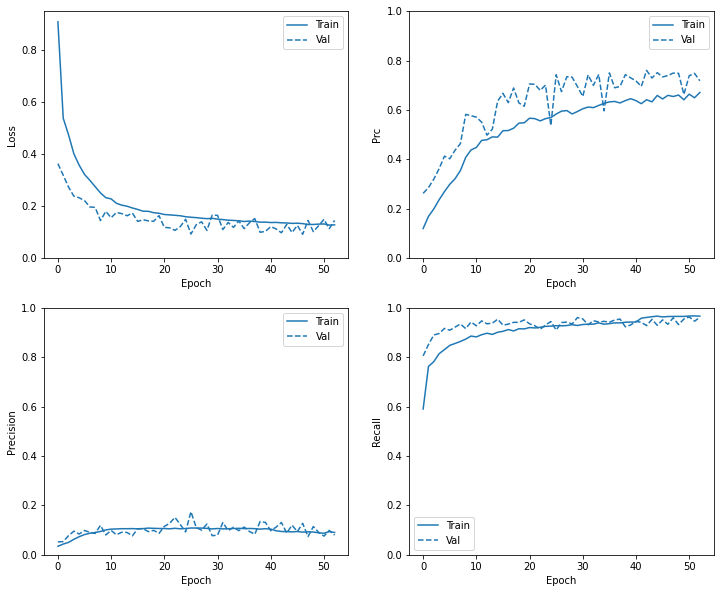

In [82]:
plot_metrics(weighted_history)

### Evaluate Metrics

In [49]:
test_ds = df_to_dataset(test_df, shuffle=False, batch_size=BATCH_SIZE)

In [85]:
train_predictions = model.predict(train_ds, batch_size=BATCH_SIZE)
test_predictions = model.predict(test_ds, batch_size=BATCH_SIZE)

In [51]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [52]:
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

loss :  0.0969950333237648
tp :  1954.0
fp :  19980.0
tn :  533594.0
fn :  191.0
accuracy :  0.9637028574943542
precision :  0.08908543735742569
recall :  0.9109557271003723
auc :  0.9836622476577759
prc :  0.6992051601409912

Legitimate Transactions Detected (True Negatives):  533594
Legitimate Transactions Incorrectly Detected (False Positives):  19980
Fraudulent Transactions Missed (False Negatives):  191
Fraudulent Transactions Detected (True Positives):  1954
Total Fraudulent Transactions:  2145


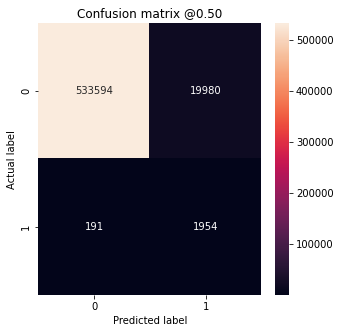

In [84]:
results = model.evaluate(test_ds, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions)

#### Plot ROC

In [91]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    # plt.xlim([-0.5,20])
    # plt.ylim([10,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [55]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

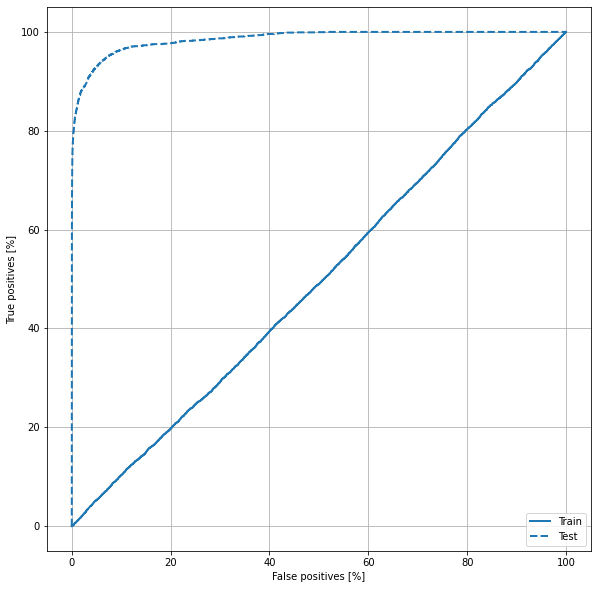

In [92]:
plot_roc("Train", train_labels, train_predictions, color=colors[0])
plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

#### Plot the AUPRC

In [65]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

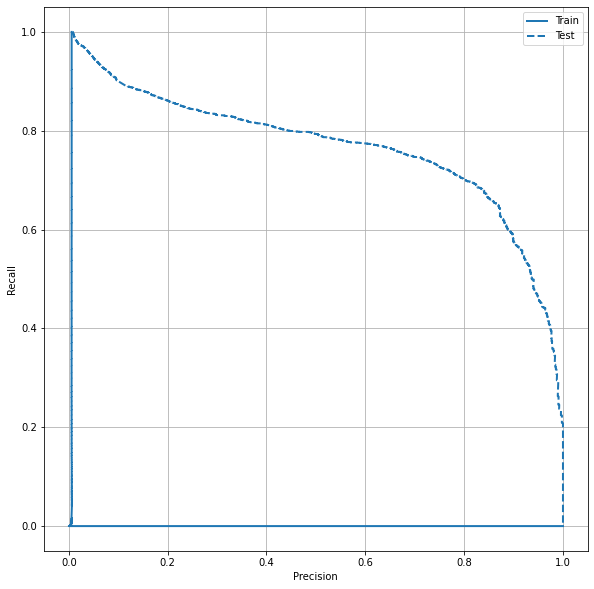

In [88]:
plot_prc("Train", train_labels, train_predictions, color=colors[0])
plot_prc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='upper right');